In [ ]:
import matplotlib.pyplot as plt
from visualizer import print_result, display_stocks_graph
import pandas as pd
import yfinance as yf
import numpy as np
from get_optimal_stocks import *
from datetime import datetime

# Define start and end dates
start_date = (2018, 1, 1)
end_date = (2020, 1, 1)
start = datetime(*start_date)
end = datetime(*end_date)

Portfolio_total_value = 1000000  # This is in dollar



In [ ]:
# Create an empty dictionary to store dataframes
stock_data = {}

# Define the stock symbols (Yahoo Finance uses different symbols compared to Quandl)
stock_symbols = ['AAPL', 'MSFT', 'AMZN']

# Fetch data from Yahoo Finance
for stock_symbol in stock_symbols:
    try:
        stock_df = yf.download(stock_symbol, start=start, end=end)
        # Process the stock data
        stock_df['Normed Return'] = stock_df['Adj Close'] / stock_df.iloc[0]['Adj Close']
        # Store the dataframe in the dictionary
        stock_data[stock_symbol] = stock_df
    except Exception as e:
        print(f"Error retrieving data for symbol: {stock_symbol}. Error message: {e}")


In [ ]:
# Access and display dataframes (similar to the original loop)
for stock_name, stock_df in stock_data.items():
    print(f"\n{stock_name} DataFrame Head:")
    print(stock_df.head())

# Generate random allocations
allocations = np.random.rand(len(stock_symbols))
# Normalize allocations so they add up to 1
allocations /= allocations.sum()
print(allocations)

# Calculate and add position values to each dataframe
for stock_symbol, allocation in zip(stock_symbols, allocations):
    stock_df = stock_data[stock_symbol]
    stock_df['Allocation'] = stock_df['Normed Return'] * allocation
    stock_df['Position Values'] = stock_df['Allocation'] * Portfolio_total_value

# Display the head of the JPM dataframe with allocation and position values
print("\nJPM DataFrame with Allocation and Position Values Head:")
print(stock_data[stock_symbols[0]].head())



In [ ]:
# Combine the position values into a single DataFrame and calculate the total position
portfolio_val = pd.concat([stock_data[symbol]['Position Values'] for symbol in stock_symbols], axis=1)
portfolio_val.columns = [f"{symbol} Pos" for symbol in stock_symbols]
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

# Display the head of the portfolio valuation DataFrame
print("\nPortfolio Valuation DataFrame Head:")
print(portfolio_val.head())

# Plot the total portfolio value
portfolio_val['Total Pos'].plot(figsize=(10, 8))
plt.title('Total Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

# Plot the individual stock position values
portfolio_val.drop('Total Pos', axis=1).plot(kind='line', figsize=(10, 8))
plt.title('Individual Stock Position Values')
plt.xlabel('Date')
plt.ylabel('Position Value')
plt.show()

portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)


In [ ]:
# Calculate the cumulative return
cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)
print('Our cumulative return is {} percent!'.format(cum_ret))

# Calculate mean daily return and standard deviation
mean_daily_return = portfolio_val['Daily Return'].mean()
std_daily_return = portfolio_val['Daily Return'].std()

# Calculate Sharpe Ratio
SR = mean_daily_return / std_daily_return
ASR = (252**0.5) * SR
print('Annualized Sharpe Ratio:', ASR)



In [ ]:
# Extract and combine the adjusted close prices into a single DataFrame for daily returns
close_data = {symbol: stock_data[symbol]['Adj Close'] for symbol in stock_symbols}
stocks = pd.DataFrame(close_data)

# Calculate logarithmic returns
log_ret = np.log(stocks / stocks.shift(1))

# One iteration example
np.random.seed(101)
weights = np.random.random(len(stock_symbols))
weights /= np.sum(weights)

exp_ret = np.sum(log_ret.mean() * weights) * 252
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
SR = exp_ret / exp_vol

In [ ]:
# Monte Carlo simulation
num_ports = 20000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
cvar_arr = np.zeros(num_ports)

for ind in range(num_ports):
    weights = np.random.random(len(stock_symbols))
    weights /= np.sum(weights)
    
    all_weights[ind, :] = weights
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]
    
    # Calculate portfolio returns for CVaR
    portfolio_returns = log_ret.dot(weights)
    portfolio_returns = portfolio_returns.dropna()  # Drop NaN values
    
    # Calculate Value at Risk (VaR)
    VaR = np.percentile(portfolio_returns, 5)
    
    # Calculate CVaR
    cvar_arr[ind] = portfolio_returns[portfolio_returns <= VaR].mean()



In [ ]:
import pandas as pd
import numpy as np


def calculate_portfolio_stats(stock_data, confidence_level):
  """
  This function calculates expected return, expected volatility, and CVaR for a portfolio.

  Args:
      stock_data: A dictionary where keys are stock symbols and values are lists of adjusted closing prices.
      confidence_level: The confidence level for CVaR calculation (e.g., 0.95).

  Returns:
      A dictionary containing expected return, expected volatility, and CVaR.
  """

  np.random.seed(101)
  stock_symbols = list(stock_data.keys())

  # Extract and combine closing prices
  close_data = {symbol: stock_data[symbol]['Adj Close'] for symbol in stock_symbols}
  stocks = pd.DataFrame(close_data)

  # Calculate logarithmic returns
  log_ret = np.log(stocks / stocks.shift(1))

    # Perform portfolio optimization to get weights
  optimal_portfolio = optimize_portfolio(stock_data)
  weights = optimal_portfolio["weights"]

  # Calculate expected return and volatility using optimal weights
  exp_ret = np.sum(log_ret.mean() * weights) * 252
  exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

  # Calculate CVaR
  # Sort the returns from lowest to highest
  sorted_returns = log_ret.sort_values(ascending=True)

  # Define the number of observations for VaR calculation based on confidence level
  num_var_observations = int(len(sorted_returns) * confidence_level)

  # Calculate VaR
  var = sorted_returns.iloc[num_var_observations - 1] * 252

  # Calculate CVaR - average of returns below VaR
  cvar = np.mean(sorted_returns[:num_var_observations]) * 252

  return {
      "expected_return": exp_ret,
      "expected_volatility": exp_vol,
      "cvar": cvar
  }

# Example usage
stock_data = {'AAPL': {'Adj Close': [100, 101, 99]},
              'IBM': {'Adj Close': [105, 103, 102]},
              'MSFT': {'Adj Close': [95, 98, 97]}}

results = calculate_portfolio_stats(stock_data, 0.95)
print(f"Expected Return: {results['expected_return']:.2f}")
print(f"Expected Volatility: {results['expected_volatility']:.2f}")
print(f"CVaR (95%): {results['cvar']:.2f}")


In [ ]:
results = calculate_portfolio_stats(stock_data, 0.95)
print(f"Expected Return: {results['expected_return']:.2f}")
print(f"Expected Volatility: {results['expected_volatility']:.2f}")
print(f"CVaR (95%): {results['cvar']:.2f}")


In [ ]:
# Identify the portfolio with the highest Sharpe Ratio
max_sr_idx = sharpe_arr.argmax()
optimal_weights = all_weights[max_sr_idx, :]


# Calculate additional metrics
years = (end - start).days / 365.25
total_return = portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1
annualized_return = (1 + total_return) ** (1 / years) - 1
annualized_volatility = vol_arr[max_sr_idx]
cagr = (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0]) ** (1 / years) - 1

# Print results
print(f'Optimal Weights: {optimal_weights}')
print(f'Expected Return: {ret_arr[max_sr_idx] * 100:.2f}%')
print(f'Expected Volatility: {vol_arr[max_sr_idx] * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_arr[max_sr_idx]:.2f}')
print(f'CVaR: {cvar_arr[max_sr_idx] * 100:.2f}%')
print(f'Annualized Return: {annualized_return * 100:.2f}%')
print(f'CAGR: {cagr * 100:.2f}%')
print(f'Annualized Volatility (Risk): {annualized_volatility * 100:.2f}%')

# Plotting the results
plt.figure(figsize=(17, 9))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol_arr[max_sr_idx], ret_arr[max_sr_idx], c='red', s=50, edgecolors='black')
plt.title('Portfolio Optimization')
plt.show()

# Output the portfolio weights
print(f'Values to be invested in each stock for portfolio of value {Portfolio_total_value} $')
for i, symbol in enumerate(stock_symbols):
    print(f'{symbol} : ${optimal_weights[i] * Portfolio_total_value}')

In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

def fetch_stock_data(stock_symbols, start, end):
    stock_data = {}
    for stock_symbol in stock_symbols:
        try:
            stock_df = yf.download(stock_symbol, start=start, end=end)
            stock_df['Normed Return'] = stock_df['Adj Close'] / stock_df.iloc[0]['Adj Close']
            stock_data[stock_symbol] = stock_df
        except Exception as e:
            print(f"Error retrieving data for symbol: {stock_symbol}. Error message: {e}")
    return stock_data



In [29]:
def calculate_portfolio_stats(stock_data, confidence_level, num_ports=20000):
    stock_symbols = list(stock_data.keys())

    close_data = {symbol: stock_data[symbol]['Adj Close'] for symbol in stock_symbols}
    stocks = pd.DataFrame(close_data)
    log_ret = np.log(stocks / stocks.shift(1))

    np.random.seed(101)
    all_weights = np.zeros((num_ports, len(stock_symbols)))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)
    cvar_arr = np.zeros(num_ports)

    for ind in range(num_ports):
        weights = np.random.random(len(stock_symbols))
        weights /= np.sum(weights)
        
        all_weights[ind, :] = weights
        ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
        sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]
        
        portfolio_returns = log_ret.dot(weights).dropna()
        VaR = np.percentile(portfolio_returns, (1-confidence_level) * 100)
        cvar_arr[ind] = portfolio_returns[portfolio_returns <= VaR].mean()

    max_sr_idx = sharpe_arr.argmax()
    optimal_weights = all_weights[max_sr_idx, :]

    return {
        "optimal_weights": optimal_weights,
        "expected_return": ret_arr[max_sr_idx],
        "expected_volatility": vol_arr[max_sr_idx],
        "sharpe_ratio": sharpe_arr[max_sr_idx],
        "cvar": cvar_arr[max_sr_idx]
    }



In [30]:
def main():
    stock_symbols = ['AAPL', 'MSFT', 'AMZN']
    start = datetime(2018, 1, 1)
    end = datetime(2023, 1, 1)
    Portfolio_total_value = 1000000  # Total portfolio value in dollars
    confidence_level = 0.95

    stock_data = fetch_stock_data(stock_symbols, start, end)
    results = calculate_portfolio_stats(stock_data, confidence_level)

    print(f"Optimal Weights: {results['optimal_weights']}")
    print(f"Expected Return: {results['expected_return'] * 100:.2f}%")
    print(f"Expected Volatility: {results['expected_volatility'] * 100:.2f}%")
    print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
    print(f"CVaR (95%): {results['cvar'] * 100:.2f}%")
    print(f"Values to be invested in each stock for portfolio of value {Portfolio_total_value} $")
    for i, symbol in enumerate(stock_symbols):
        print(f'{symbol} : ${results["optimal_weights"][i] * Portfolio_total_value:.2f}')

if __name__ == "__main__":
    main()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Optimal Weights: [0.44594346 0.55306171 0.00099483]
Expected Return: 22.35%
Expected Volatility: 30.29%
Sharpe Ratio: 0.74
CVaR (95%): -4.48%
Values to be invested in each stock for portfolio of value 1000000 $
AAPL : $445943.46
MSFT : $553061.71
AMZN : $994.83


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Optimal Weights: [0.44594346 0.55306171 0.00099483]
Expected Return: 22.35%
Expected Volatility: 30.29%
Sharpe Ratio: 0.74
CVaR (95%): -4.48%
Values to be invested in each stock for portfolio of value 1000000 $
AAPL : $445943.46
MSFT : $553061.71
AMZN : $994.83


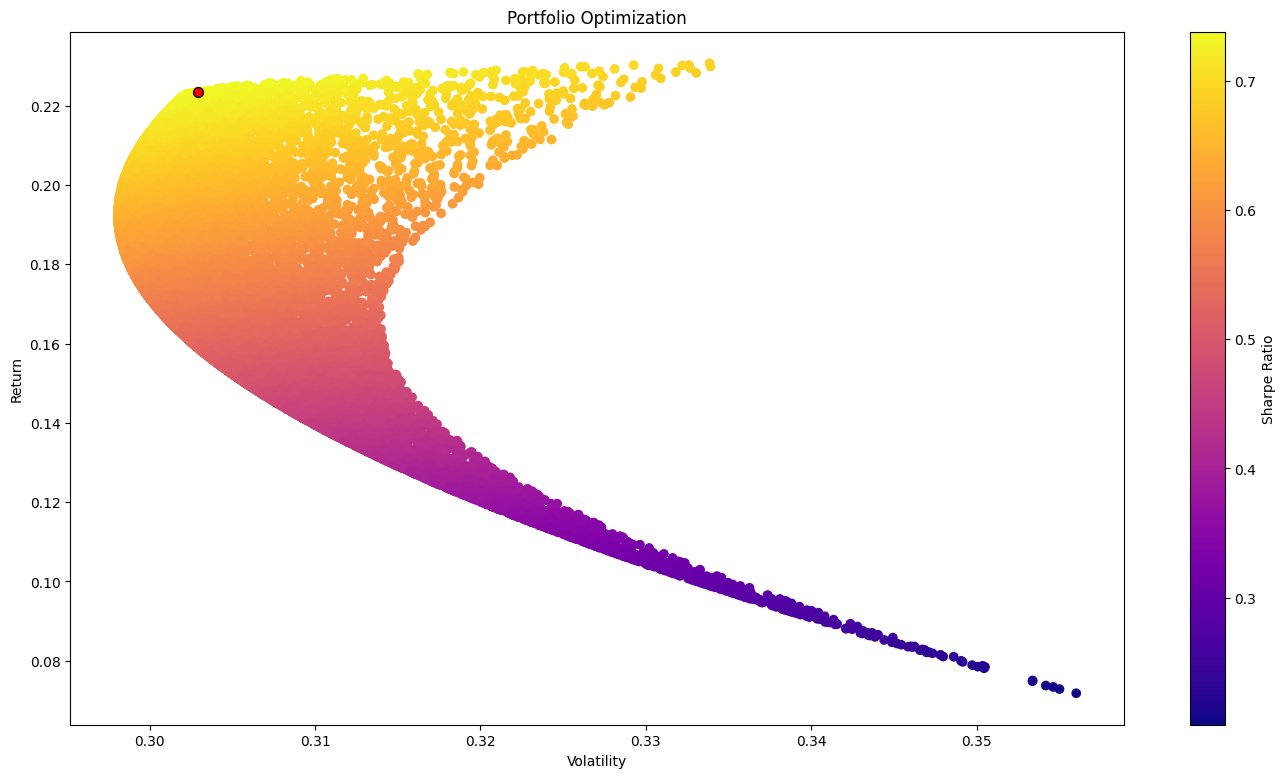

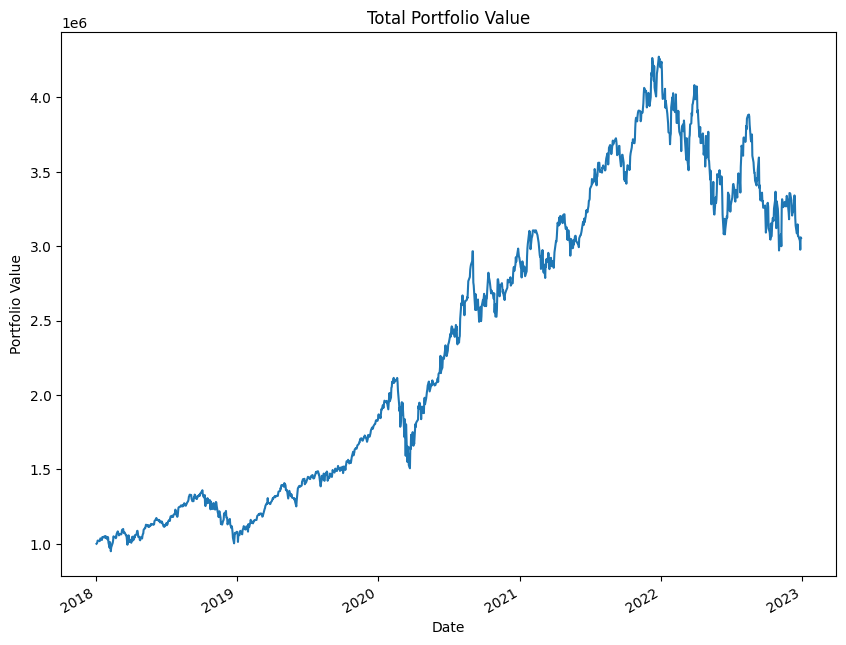

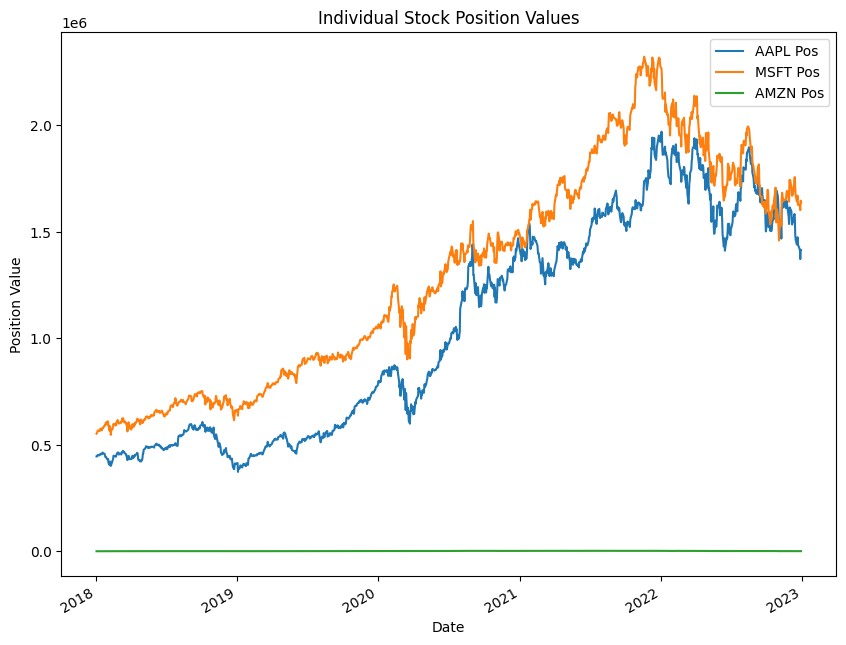

Our cumulative return is 205.4998382625448 percent!


C:\Users\awadh\AppData\Local\Temp\ipykernel_13168\962025669.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)


In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

def fetch_stock_data(stock_symbols, start, end):
    stock_data = {}
    for stock_symbol in stock_symbols:
        try:
            stock_df = yf.download(stock_symbol, start=start, end=end)
            stock_df['Normed Return'] = stock_df['Adj Close'] / stock_df.iloc[0]['Adj Close']
            stock_data[stock_symbol] = stock_df
        except Exception as e:
            print(f"Error retrieving data for symbol: {stock_symbol}. Error message: {e}")
    return stock_data

def calculate_portfolio_stats(stock_data, confidence_level, num_ports=20000):
    stock_symbols = list(stock_data.keys())
    close_data = {symbol: stock_data[symbol]['Adj Close'] for symbol in stock_symbols}
    stocks = pd.DataFrame(close_data)
    log_ret = np.log(stocks / stocks.shift(1))

    np.random.seed(101)
    all_weights = np.zeros((num_ports, len(stock_symbols)))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)
    cvar_arr = np.zeros(num_ports)

    for ind in range(num_ports):
        weights = np.random.random(len(stock_symbols))
        weights /= np.sum(weights)
        
        all_weights[ind, :] = weights
        ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
        sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]
        
        portfolio_returns = log_ret.dot(weights).dropna()
        VaR = np.percentile(portfolio_returns, (1-confidence_level) * 100)
        cvar_arr[ind] = portfolio_returns[portfolio_returns <= VaR].mean()

    max_sr_idx = sharpe_arr.argmax()
    optimal_weights = all_weights[max_sr_idx, :]

    return {
        "optimal_weights": optimal_weights,
        "expected_return": ret_arr[max_sr_idx],
        "expected_volatility": vol_arr[max_sr_idx],
        "sharpe_ratio": sharpe_arr[max_sr_idx],
        "cvar": cvar_arr[max_sr_idx],
        "all_weights": all_weights,
        "ret_arr": ret_arr,
        "vol_arr": vol_arr,
        "sharpe_arr": sharpe_arr
    }

def main():
    stock_symbols = ['AAPL', 'MSFT', 'AMZN']
    start = datetime(2018, 1, 1)
    end = datetime(2023, 1, 1)
    Portfolio_total_value = 1000000  # Total portfolio value in dollars
    confidence_level = 0.95

    stock_data = fetch_stock_data(stock_symbols, start, end)
    results = calculate_portfolio_stats(stock_data, confidence_level)

    print(f"Optimal Weights: {results['optimal_weights']}")
    print(f"Expected Return: {results['expected_return'] * 100:.2f}%")
    print(f"Expected Volatility: {results['expected_volatility'] * 100:.2f}%")
    print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
    print(f"CVaR (95%): {results['cvar'] * 100:.2f}%")
    print(f"Values to be invested in each stock for portfolio of value {Portfolio_total_value} $")
    for i, symbol in enumerate(stock_symbols):
        print(f'{symbol} : ${results["optimal_weights"][i] * Portfolio_total_value:.2f}')

    # Visualization
    plt.figure(figsize=(17, 9))
    plt.scatter(results['vol_arr'], results['ret_arr'], c=results['sharpe_arr'], cmap='plasma')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.scatter(results['vol_arr'][results['sharpe_arr'].argmax()], results['ret_arr'][results['sharpe_arr'].argmax()], c='red', s=50, edgecolors='black')
    plt.title('Portfolio Optimization')
    plt.show()

    # Combine the position values into a single DataFrame and calculate the total position
    portfolio_val = pd.concat([stock_data[symbol]['Normed Return'] * results['optimal_weights'][i] * Portfolio_total_value for i, symbol in enumerate(stock_symbols)], axis=1)
    portfolio_val.columns = [f"{symbol} Pos" for symbol in stock_symbols]
    portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

    # Plot the total portfolio value
    portfolio_val['Total Pos'].plot(figsize=(10, 8))
    plt.title('Total Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Plot the individual stock position values
    portfolio_val.drop('Total Pos', axis=1).plot(kind='line', figsize=(10, 8))
    plt.title('Individual Stock Position Values')
    plt.xlabel('Date')
    plt.ylabel('Position Value')
    plt.show()

    portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)
    cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)
    print('Our cumulative return is {} percent!'.format(cum_ret))

if __name__ == "__main__":
    main()
